Learning to Learn - John Tomlinson, Ahan Maurya, Dr. Jing Wang

First we need to import the modules we created for this notebook

In [43]:
import meta_network
import original_network
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# Reload to pick up on-disk changes to original_network
import importlib
importlib.reload(original_network)
importlib.reload(meta_network)

<module 'meta_network' from 'c:\\Users\\bobtt\\OneDrive\\Desktop\\Documents\\JackCS\\learning-to-learn\\cartpole-implementation\\meta_network.py'>

We will start by initializing both of our networks

In [45]:
cartpole_network, cartpole_target_network,memory, optimizer, device, env = original_network.build_model()

Now lets build a function to graph our reward over time

In [36]:
def plot_rewards(reward_list):
    plt.plot(reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward over Time')
    plt.scatter(range(len(reward_list)), reward_list, marker='o', color='red')
    plt.show()


Lets make a training loop to get our baseline performance for our model wihtout the meta learning

In [7]:
NUM_EPISODES = 2000
TARGET_UPDATE = 10

In [8]:
def training_loop(episodes):
    total_reward_list = []
    epsilon = 0.1  # Exploration rate
    best_reward = 0
    for episode in range(episodes):
        state, _ = env.reset()
        processed_state = original_network.process_state(state)
        done = False
        total_reward = 0

        frames = []
        while not done:
            action = original_network.select_action(processed_state, cartpole_network, device, epsilon, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            processed_next_state = original_network.process_state(next_state)
            memory.push(processed_state, action, reward, processed_next_state, done)
            processed_state = processed_next_state
            total_reward += reward
            
            if episode > 1000:
                frame = env.render()
                frames.append(frame)

        original_network.optimize_model(cartpole_network, cartpole_target_network, memory, optimizer, device)

        if episode % TARGET_UPDATE == 0:
            cartpole_target_network.load_state_dict(cartpole_network.state_dict())
        
        if episode % 30 == 0:
            print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
        total_reward_list.append(total_reward)

        best_reward = original_network.save_best_model(episode, best_reward, total_reward, frames)
    return total_reward_list

Episode 1/2000, Total Reward: 8.0
Episode 31/2000, Total Reward: 12.0
Episode 31/2000, Total Reward: 12.0
Episode 61/2000, Total Reward: 10.0
Episode 61/2000, Total Reward: 10.0
Episode 91/2000, Total Reward: 9.0
Episode 91/2000, Total Reward: 9.0
Episode 121/2000, Total Reward: 9.0
Episode 121/2000, Total Reward: 9.0
Episode 151/2000, Total Reward: 9.0
Episode 151/2000, Total Reward: 9.0
Episode 181/2000, Total Reward: 10.0
Episode 181/2000, Total Reward: 10.0
Episode 211/2000, Total Reward: 38.0
Episode 211/2000, Total Reward: 38.0
Episode 241/2000, Total Reward: 10.0
Episode 241/2000, Total Reward: 10.0
Episode 271/2000, Total Reward: 10.0
Episode 271/2000, Total Reward: 10.0
Episode 301/2000, Total Reward: 10.0
Episode 301/2000, Total Reward: 10.0
Episode 331/2000, Total Reward: 21.0
Episode 331/2000, Total Reward: 21.0
Episode 361/2000, Total Reward: 37.0
Episode 361/2000, Total Reward: 37.0
Episode 391/2000, Total Reward: 31.0
Episode 391/2000, Total Reward: 31.0
Episode 421/2000

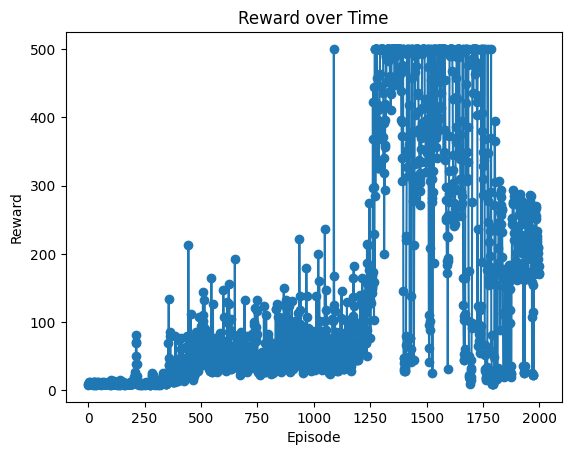

In [9]:
plot_rewards(training_loop(NUM_EPISODES))

In [ ]:
rewards

Now that we have a baseline for our reinforcenet learning loop we can try training with our met network that will automatically shape our network.

In [56]:
inputs_dim = env.action_space.n + 2
meta_network_test, meta_memory = meta_network.build_model(inputs_dim)

In [57]:
def training_loop_meta(episodes):
    total_reward_list = []
    epsilon = 0.1  # Exploration rate
    best_reward = 0
    for episode in range(episodes):
        state, _ = env.reset()
        processed_state = original_network.process_state(state)
        done = False
        total_reward = 0

        frames = []
        while not done:

            action = original_network.select_action(processed_state, cartpole_network, device, epsilon,env)
            next_state, reward, terminated, truncated, _ = env.step(action)


            shaped_reward = meta_network.select_action(processed_state, action, reward, meta_network_test, device, epsilon, inputs_dim)

            done = terminated or truncated

            processed_next_state = original_network.process_state(next_state)

            memory.push(processed_state, action, (reward+shaped_reward), processed_next_state, done)
            

            processed_state = processed_next_state
            total_reward += reward
            
            if episode > 1000:
                frame = env.render()
                frames.append(frame)

        original_network.optimize_model(cartpole_network, cartpole_target_network, memory, optimizer, device)
        
        meta_reward_data = meta_network.sliding_window(total_reward_list,50)
        meta_network_reward = meta_network.compute_reward(meta_reward_data)

        meta_state = np.append(processed_state, action)
        meta_memory.push(meta_state, shaped_reward, meta_network_reward, processed_next_state, True)
        meta_network.optimize_model(meta_network_test, meta_memory, device)
        
        if episode % TARGET_UPDATE == 0:
            cartpole_target_network.load_state_dict(cartpole_network.state_dict())
        
        if episode % 30 == 0:
            print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
        total_reward_list.append(total_reward)

        best_reward = original_network.save_best_model(episode, best_reward, total_reward, frames)
    return total_reward_list

In [58]:
training_loop_meta(100)

Episode 1/100, Total Reward: 10.0
Episode 31/100, Total Reward: 10.0
Episode 31/100, Total Reward: 10.0
Episode 61/100, Total Reward: 8.0
Episode 61/100, Total Reward: 8.0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x6 and 4x1)